In [1]:
import tensorflow as tf
import inception_preprocessing
import numpy as np
from inception_resnet_v2 import inception_resnet_v2, inception_resnet_v2_arg_scope
from tensorflow.contrib import slim
import os
from matplotlib import pyplot as plt
import cv2

Reading images...
Number of images : 64
Pre-processing images...
Creating model...
/Users/haewonpark/Projects/handson/Food_Classification/output/log/model.ckpt-4350
Loading trained parameters...
INFO:tensorflow:Restoring parameters from /Users/haewonpark/Projects/handson/Food_Classification/output/log/model.ckpt-4350
Starting the Classification
Now processing 0 - 31 image
0-th image


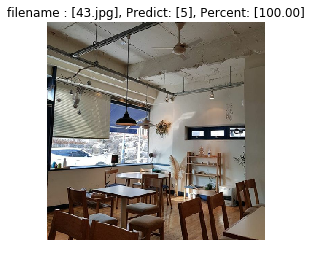

1-th image


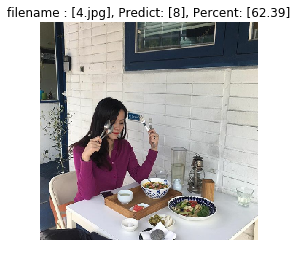

2-th image


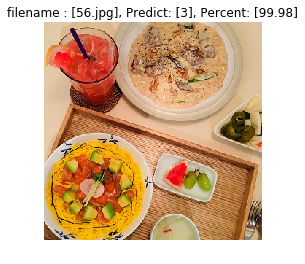

3-th image


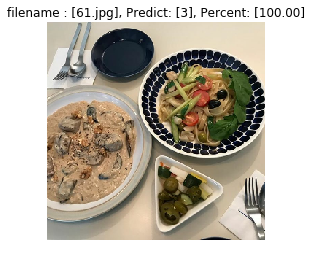

4-th image


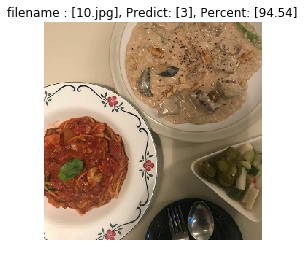

5-th image


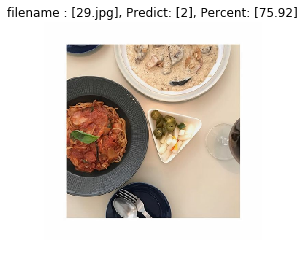

6-th image


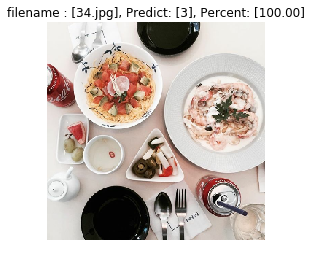

7-th image


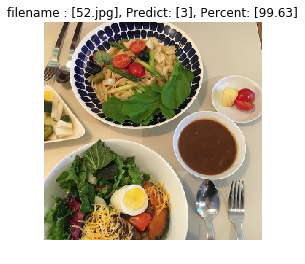

8-th image


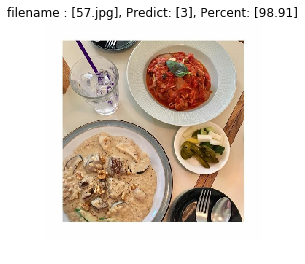

9-th image


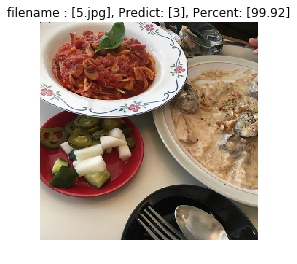

10-th image


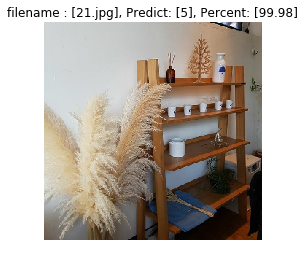

11-th image


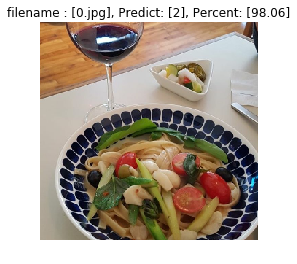

12-th image


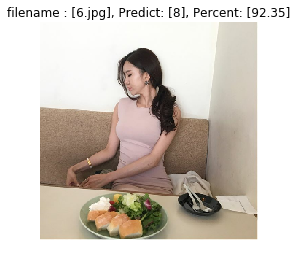

13-th image


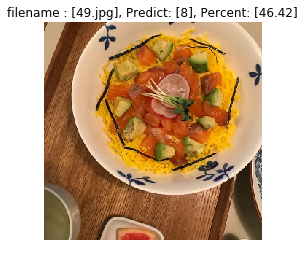

14-th image


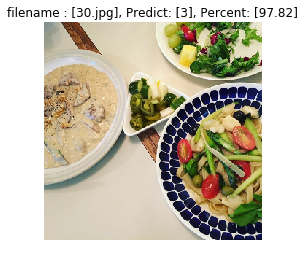

15-th image


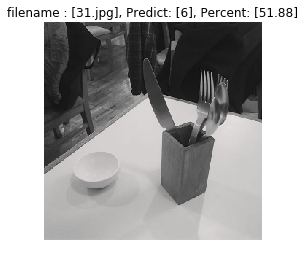

16-th image


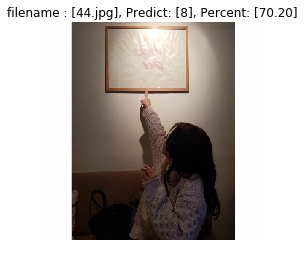

17-th image


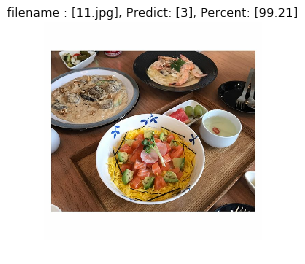

18-th image


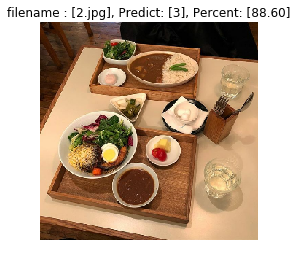

19-th image


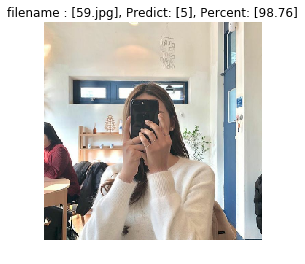

20-th image


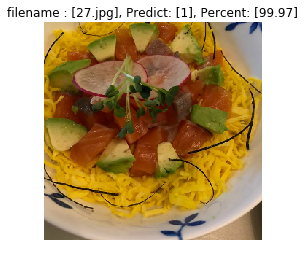

21-th image


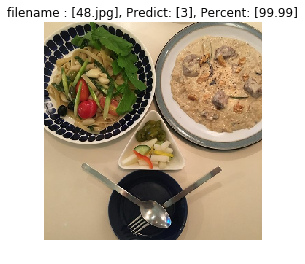

22-th image


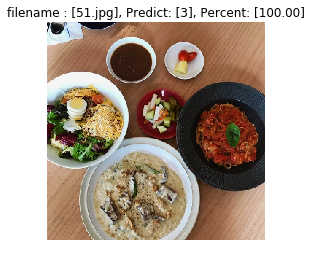

23-th image


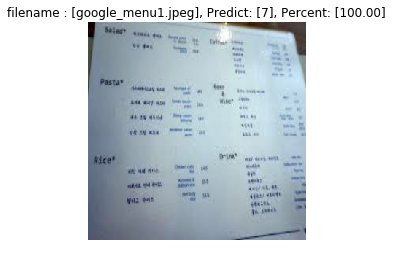

24-th image


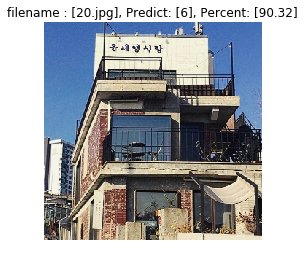

25-th image


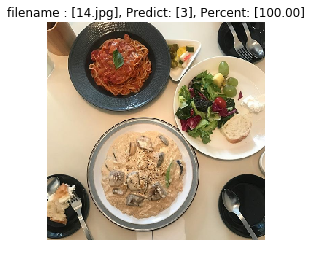

26-th image


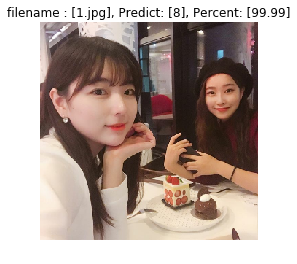

27-th image


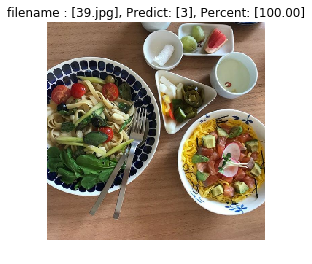

28-th image


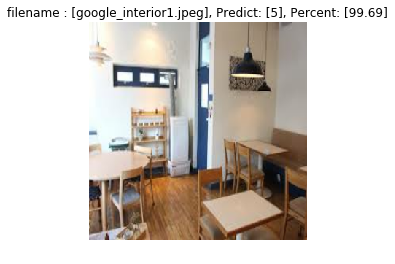

29-th image


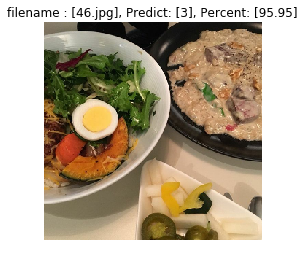

30-th image


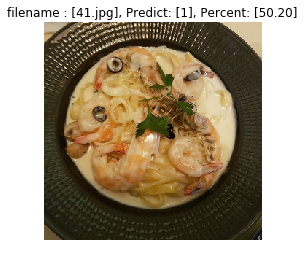

31-th image


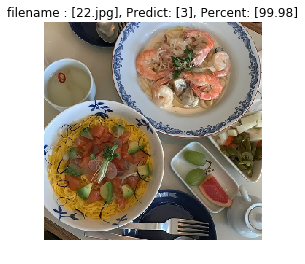

Now processing 32 - 63 image
32-th image


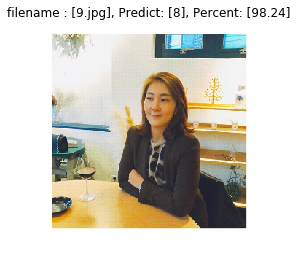

33-th image


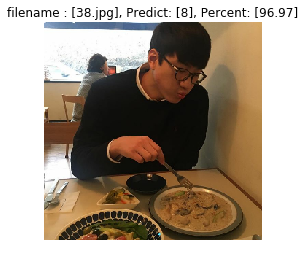

34-th image


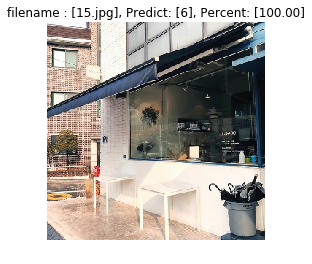

35-th image


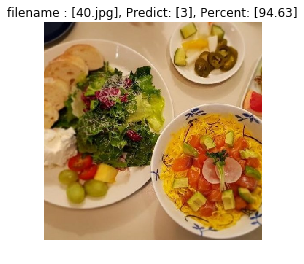

36-th image


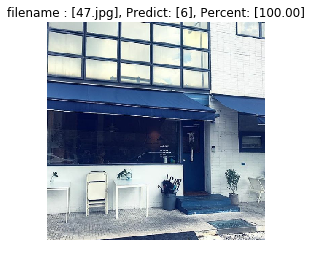

37-th image


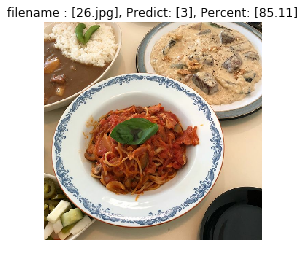

38-th image


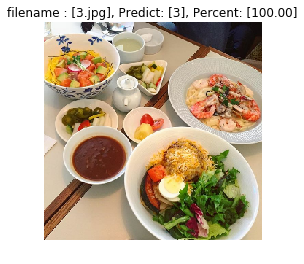

39-th image


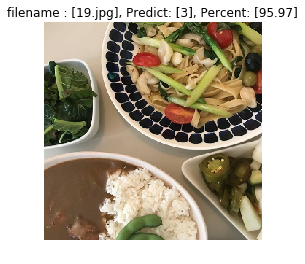

40-th image


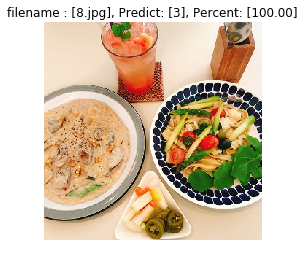

41-th image


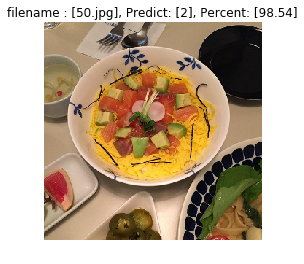

42-th image


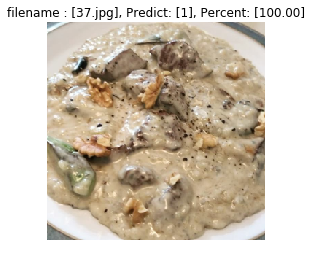

43-th image


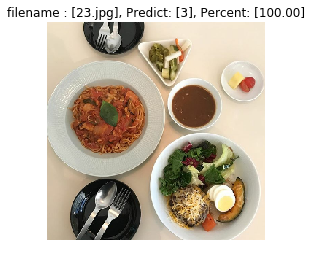

44-th image


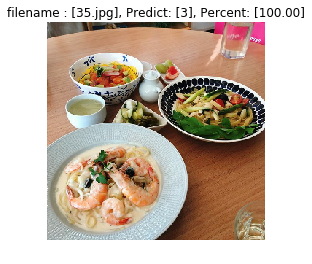

45-th image


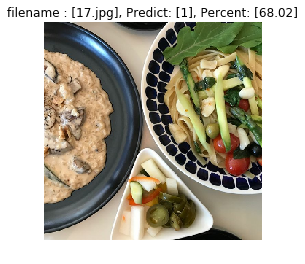

46-th image


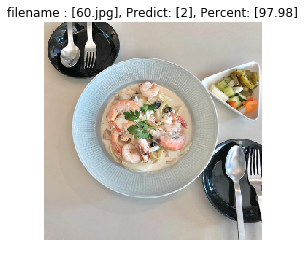

47-th image


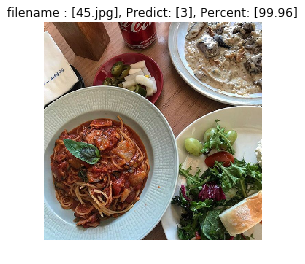

48-th image


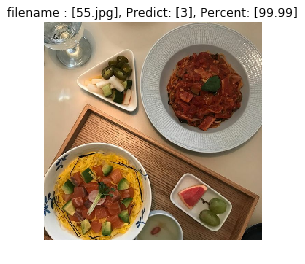

49-th image


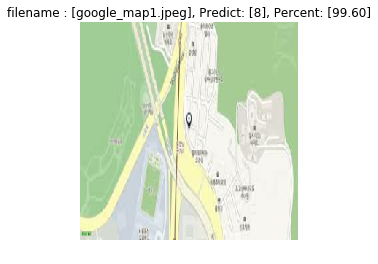

50-th image


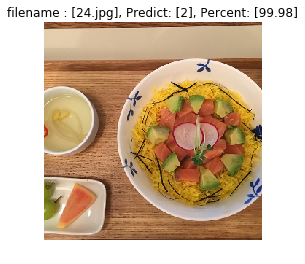

51-th image


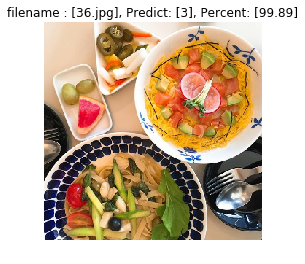

52-th image


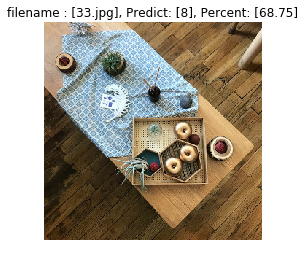

53-th image


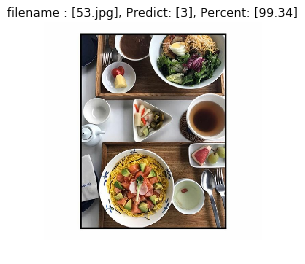

54-th image


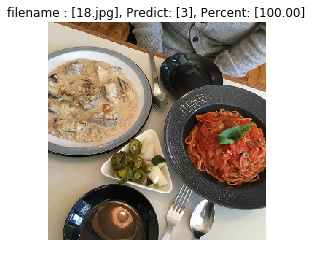

55-th image


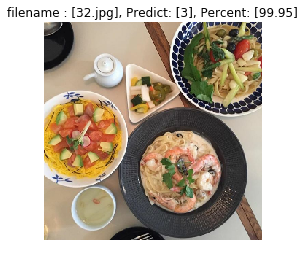

56-th image


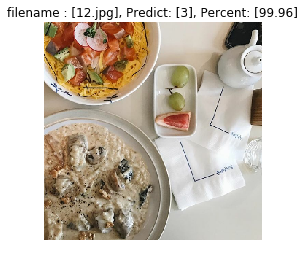

57-th image


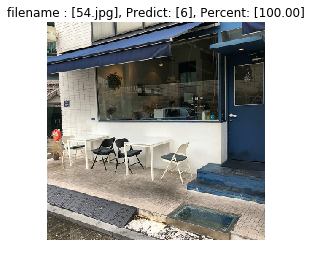

58-th image


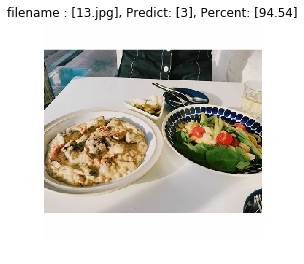

59-th image


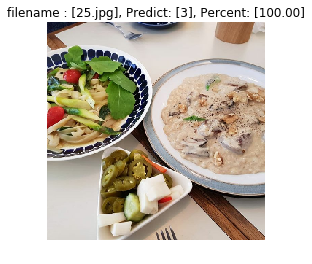

60-th image


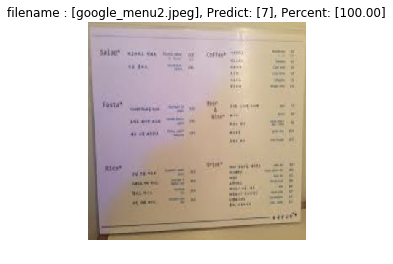

61-th image


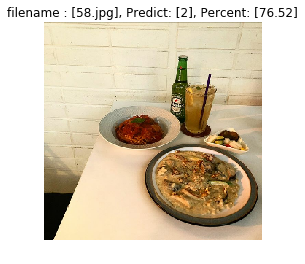

62-th image


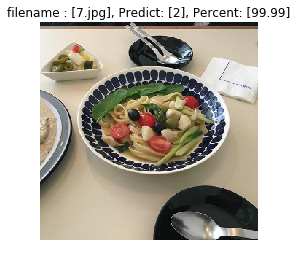

63-th image


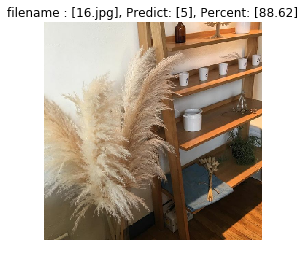

Finished


In [2]:
# path to our trained model
checkpoint_path = '/Users/haewonpark/Projects/handson/Food_Classification/output/log/'
# path to images folder
img_dir = '/Users/haewonpark/Projects/handson/Food_Classification/images/all'

# save directory
save_dir = img_dir + '/../category_AI'
batch_size=32

height = width = inception_resnet_v2.default_image_size
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
with tf.Graph().as_default():
    print("Reading images...")
    # read images
    files = os.listdir(img_dir)
    print("Number of images : %d" %(len(files)))
    filename_queue = tf.train.string_input_producer([(img_dir+"/"+name) for name in files])

    image_reader = tf.WholeFileReader()
    key, image_file = image_reader.read(filename_queue)

    print("Pre-processing images...")
    # image pre-processing
    img = tf.image.decode_jpeg(image_file, channels=3)
    processed_img = inception_preprocessing.preprocess_image(img, height, width, is_training=False)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(img, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    #processed_imgs = tf.expand_dims(processed_img, 0)

    # load images as batch 
    num_process_threads = 4
    min_queue_examples = 256
    raw_imgs, processed_imgs, keys = tf.train.batch(
    [image_raw, processed_img, key], batch_size=batch_size, num_threads=1, capacity=2*batch_size,allow_smaller_final_batch=True)
    
    print("Creating model...")
    # Create the model, use the default arg scope to configure the batch norm parameters.
    # If our model trained with is_training = False at final stage, 
    # then create test model with is_training = False
    with slim.arg_scope(inception_resnet_v2_arg_scope()):
        logits, end_points = inception_resnet_v2(processed_imgs, num_classes=9, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    # Set checkpoints restoring function
    if tf.gfile.IsDirectory(checkpoint_path):
        checkpoint_path =  tf.train.latest_checkpoint(checkpoint_path)
        print(checkpoint_path)
        variables_to_restore = slim.get_variables_to_restore()
        #variables_to_restore = slim.get_model_variables('InceptionResnetV2')
        #print(variables_to_restore)
        init_fn = slim.assign_from_checkpoint_fn(
            checkpoint_path,
            variables_to_restore)
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            tf.global_variables_initializer().run()
            print("Loading trained parameters...")
            init_fn(sess)
            print("========================================================")
            print("Starting the Classification")
            print("========================================================")
            for index in range(len(files)):
                i = index % batch_size
                if i == 0 : 
                    # Run one batch 
                    print("Now processing %d - %d image" % (index, index+batch_size-1))
                    np_raw_imgs, np_processed_images, np_keys, np_probabilities = sess.run([raw_imgs, processed_imgs, keys, probabilities])
                
                image = np_raw_imgs[i,:,:,:]
                predicted_label = np.argmax(np_probabilities[i,:])
                prob = np_probabilities[i,predicted_label]*100
                imagename = np_keys[i].decode(encoding='utf-8')
                start = imagename.rfind('/')
                imagename = imagename[start+1:]
                
                if True :
                    print("%d-th image" % (index))
                    plt.figure()
                    plt.imshow(image.astype(np.uint8))
                    plt.title('filename : [%s], Predict: [%s], Percent: [%.2f]' % (imagename, predicted_label, prob))
                    plt.axis('off')
                    plt.show()
                
                # make category dirs, if not exist
                category_path = save_dir + '/' + np.array2string(predicted_label)
                if not os.path.exists(category_path):
                    os.makedirs(category_path)
                # save image to new classified category folder
                cv2.imwrite(category_path + '/' + str(int(prob))+'_'+imagename,cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
                

print("Finished")
                
        
        #coord.request_stop()
        #coord.join(threads)